In [178]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/kirill/Projects/NIR')
sys.path.append('/home/kirilman/Projects/nir/nir/')

import myutils
import numpy as np
import matplotlib.pylab as plt
from pomegranate import *
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, minmax_scale, StandardScaler
pd.set_option('display.max_columns', 40)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [179]:
def read_data(start_index, stop_index):
    with open('kdd_test.txt','r') as file:
        data = []
        target = []
        for i,line in enumerate(file):
            if i == 0:
                continue
            elems = line.replace('\n','').split(',')
            data += [[float(x) for x in elems[start_index:stop_index]]]
            target += [elems[41]]
    return data, target

In [219]:
data, target = read_data(4,8)
# test_data = data[80000:100000]
# test_target = target[80000:100000]
# data = data[:80000]
# target = target[:80000]


#test_data = data[6000:7000]
# test_target = target[6000:7000]
data = data[:125000]
# target = target[:30000]

In [220]:
frame = pd.DataFrame(data)
frame[frame.shape[1]] = pd.DataFrame(target)
frame.tail()

,0,1,2,3,4
124995,0.0,0.0,0.0,0.0,neptune
124996,0.0,0.0,0.0,0.0,neptune
124997,0.0,0.0,0.0,0.0,neptune
124998,0.0,0.0,0.0,0.0,neptune
124999,0.0,0.0,0.0,0.0,neptune


In [221]:
a = frame[frame.shape[1]-1].value_counts()>2000
uses_classes = []
for i,x in enumerate(a):
    if x:
        uses_classes+=[a.index[i]]
uses_classes

arr_mask = []
for cl in uses_classes:
    arr_mask+=[frame.loc[:,frame.shape[1]-1] == cl]
    
for i,cur_mask in enumerate(arr_mask):
    if i == 0:
        mask = np.zeros((frame.shape[0]),dtype = bool)
        #mask = mask | cur_mask
    else:
        mask = mask | cur_mask
print(np.sum(mask))

frame = frame[mask]

62104


In [222]:
# test_data = data[6000:7000]
# test_target = target[6000:7000]
p = int(len(frame)*0.8)
test_data = frame.drop(frame.shape[1]-1,axis=1).values[:p]
test_target = frame[frame.shape[1]-1].values[:p]

data = frame.drop(frame.shape[1]-1,axis=1).values[:p]
target = frame[frame.shape[1]-1].values[:p]



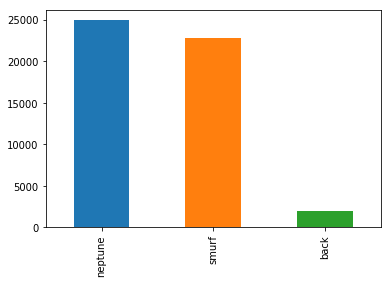

In [223]:
pd.DataFrame(target)[0].value_counts().plot.bar()
#target.value_counts().plot.bar()

In [224]:

#нормализация
# data = pd.DataFrame(minmax_scale(data))
# test_data = pd.DataFrame(minmax_scale(test_data))
data = StandardScaler().fit_transform(data)
test_data = StandardScaler().fit_transform(test_data)

data = pd.DataFrame(data)
test_data = pd.DataFrame(test_data)

states = {}
target = pd.DataFrame(target)
N_comp = len(pd.unique(target[0]))
print('Количество состояний {}'.format(N_comp))
for i,elem in enumerate(pd.unique(target[0].values)):
    states[elem] = i
print(states)

y_train = []
for x in target[0]:
    y_train+=[states[x]]
print(len(y_train))
y_train = list(map(str,y_train))
y_train = list(map(myutils.rename_state,y_train))

print(y_train[:10])
x_train = data.values.tolist()
print(len(x_train), len(y_train))

Количество состояний 3
{'neptune': 0, 'smurf': 1, 'back': 2}
49683
['s0', 's0', 's1', 's1', 's1', 's1', 's1', 's1', 's1', 's1']
49683 49683


In [225]:
x_train[0]

[-0.25088857386105584, -0.20447314396615218, 0.0, 0.0]

In [226]:
frame = pd.DataFrame(x_train)
frame.describe()

,0,1,2,3
count,4.968300e+04,4.968300e+04,49683.0,49683.0
mean,1.301486e-13,-3.410006e-14,0.0,0.0
std,1.000010e+00,1.000010e+00,0.0,0.0
min,-2.508886e-01,-2.044731e-01,0.0,0.0
25%,-2.508886e-01,-2.044731e-01,0.0,0.0
50%,-2.508886e-01,-2.044731e-01,0.0,0.0
75%,-1.535420e-01,-2.044731e-01,0.0,0.0
max,4.893764e+00,4.910149e+00,0.0,0.0


In [227]:
model = HiddenMarkovModel.from_samples(MultivariateGaussianDistribution, n_components = N_comp,X = [x_train],
                                       labels=[y_train],algorithm='labeled' )
# model = HiddenMarkovModel.from_samples(MultivariateGaussianDistribution, n_components = N_comp,X = [x_train],
#                                       lr_decay = 0.9)
model

{
    "class" : "HiddenMarkovModel",
    "name" : "None",
    "start" : {
        "class" : "State",
        "distribution" : null,
        "name" : "None-start",
        "weight" : 1.0
    },
    "end" : {
        "class" : "State",
        "distribution" : null,
        "name" : "None-end",
        "weight" : 1.0
    },
    "states" : [
        {
            "class" : "State",
            "distribution" : {
                "class" : "Distribution",
                "name" : "MultivariateGaussianDistribution",
                "parameters" : [
                    [
                        -0.2506782798500385,
                        -0.20426798461590862,
                        0.0,
                        0.0
                    ],
                    [
                        [
                            0.0010621442647613566,
                            0.0010554303700947396,
                            0.0,
                            0.0
                        ],
                

In [228]:
#Тестовая выборка
y_test = []
for x in test_target:
    #if x == 'loadmodule' or x=='perl':
        #continue
    y_test += [states[x]]
x_test = test_data

In [229]:
y_pr = model.predict(x_test)
print(y_pr[:10])
print(y_test[:10])
acc = np.sum(np.array(y_pr) == np.array(y_test))/len(y_pr)
print(acc)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
0.04029547330072661


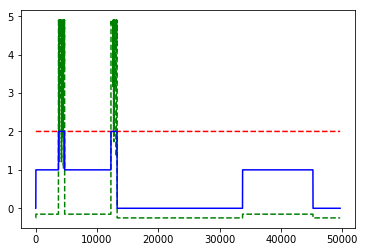

In [230]:
plt.plot(y_pr,'r--')
plt.plot(x_test[0],'g--')
plt.plot(y_test,'b')

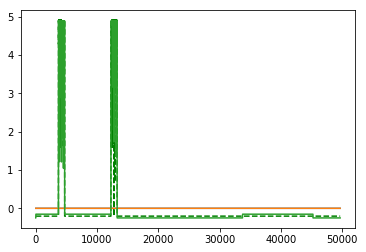

In [235]:
plt.plot(x_test[1],'g--')
plt.plot(x_test[2])
plt.plot(x_test[3])
plt.plot(x_test[0])

In [148]:
a = np.array([[1,2],[2,3],[0,5.]])
StandardScaler().fit_transform(a)

array([[ 0.        , -1.06904497],
       [ 1.22474487, -0.26726124],
       [-1.22474487,  1.33630621]])

In [190]:
1/np.sqrt(2)

0.7071067811865475

In [191]:
np.std([1,2,0])

0.816496580927726

In [195]:
np.sqrt(2/3)

0.816496580927726